In [1]:
import foam_ct_phantom
import numpy as np
from pathlib import Path
import pylab as pl
from scipy.optimize import minimize
import tomopy
pl.gray()

# configuration parameters
random_seed = 314159 # random seed to get repeatable results
phantom_path = Path('phantom.h5') # stores phantom object path
phantom_par_path = Path('projs_par.h5') # stores phantom parameters path
phantom_vol_path = Path('phantom_volume.h5') # generated phantom volume path
phantom_projs_path = Path('phantom_projs.h5')  # simulated projections through phantom path
size = 256  # image size for projections
max_shift = 16  # max amount of shifting (we'll need this extra area for cropping)
sim_size = size + 2*max_shift
pixel_size = 3/size
#thetas = np.linspace(0, np.pi, 128, False)
thetas = np.linspace(np.deg2rad(30), np.deg2rad(150), 128, False)

In [2]:
# create phantom file if it doesn't already exist
if not phantom_path.exists():
    # Note that nspheres_per_unit is set to a low value to reduce the computation time here.
    # The default value is 100000.
    foam_ct_phantom.FoamPhantom.generate(str(phantom_path), random_seed, nspheres_per_unit=1000)

phantom = foam_ct_phantom.FoamPhantom(str(phantom_path))

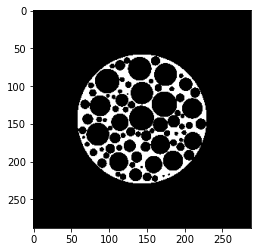

In [3]:
# create phantom volume
geom = foam_ct_phantom.VolumeGeometry(sim_size, sim_size, sim_size, pixel_size)
if not phantom_vol_path.exists():
    phantom.generate_volume(str(phantom_vol_path), geom)

vol = foam_ct_phantom.load_volume(str(phantom_vol_path))

# visualize
pl.imshow(vol[vol.shape[0]//2])
pl.show()

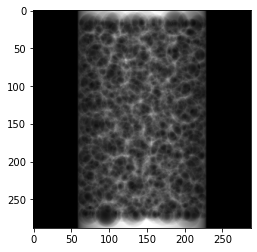

In [4]:
# create projections
proj_geom = foam_ct_phantom.ParallelGeometry(sim_size, sim_size, thetas, pixel_size)
if not phantom_projs_path.exists():
    phantom.generate_projections(str(phantom_projs_path), proj_geom)

projs = foam_ct_phantom.load_projections(str(phantom_projs_path))

# visualize
pl.imshow(projs[projs.shape[0]//2])
pl.show()

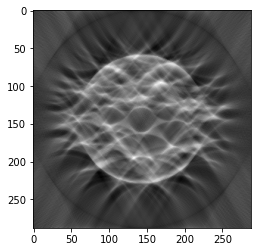

In [5]:
# Reconstruct with no shifts applied
rec = tomopy.recon(projs, thetas, algorithm="sirt", num_iter=30)

pl.imshow(rec[rec.shape[0]//2])
pl.show()

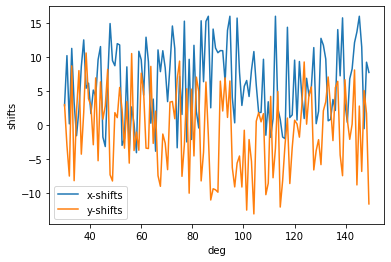

In [6]:
# shift projections
# create shifts for projections
# TODO: add different types of shifts: periodic (see this on stages), y drift in one direction
random_shift_size = 10 # shift up to this many pixels in x and y
center_offset_shift = 6
random_walk_size = 0.5

# apply random shifts
shifts = np.random.random_sample((projs.shape[0], 2)) # (y,x) order
shifts *= random_shift_size * 2
shifts -= random_shift_size

# apply center offset shifts
shifts[:, 1] += center_offset_shift

# apply random walk shifts
random_walk_shifts = np.random.random_sample((projs.shape[0], 2)) # (y,x) order
random_walk_shifts *= random_walk_size * 2
random_walk_shifts -= random_walk_size
random_walk_shifts = np.cumsum(random_walk_shifts, axis=0)
shifts += random_walk_shifts

# limit overall shift size to max_shift
np.clip(shifts, -max_shift, max_shift, shifts)

# shift projections and then crop using max_shift (shift in projection space)
tomopy.exp_minus(projs, out=projs)
projs = tomopy.shift_images(projs, shifts[:, 1], shifts[:, 0])
projs = projs[:, max_shift:max_shift+size, max_shift:max_shift+size]
np.clip(projs, 1e-6, 1-1e-6, projs)
tomopy.minus_log(projs, out=projs)

pl.plot(np.rad2deg(thetas), shifts[:, 1], label="x-shifts")
pl.plot(np.rad2deg(thetas), shifts[:, 0], label="y-shifts")
pl.xlabel("deg")
pl.ylabel("shifts")
pl.legend()
pl.show()

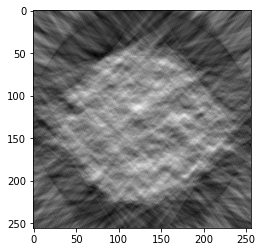

In [7]:
# Reconstruct with shifts applied
rec = tomopy.recon(projs, thetas, algorithm="sirt", num_iter=30)

pl.imshow(rec[rec.shape[0]//2])
pl.show()

iter=0, err=66.44067579427531
iter=1, err=50.1783304823905
iter=2, err=13.666589964215653
iter=3, err=5.515260717432133
iter=4, err=3.506460443773749
iter=5, err=2.2657752536383655
iter=6, err=1.6056942131831946
iter=7, err=1.3167161449036757
iter=8, err=1.2037509735198553
iter=9, err=1.1498997918297056
iter=10, err=1.1123381202449194
iter=11, err=1.0887449770263011
iter=12, err=1.0651687072947644
iter=13, err=1.0412342435782644
iter=14, err=1.0242691754368087
iter=15, err=1.0028506244700663
iter=16, err=0.9835712988899178
iter=17, err=0.9725289198784789
iter=18, err=0.9680973608062363
iter=19, err=0.9517943580416933
iter=20, err=0.9467675269040441
iter=21, err=0.9294458194268247
iter=22, err=0.9230219559956311
iter=23, err=0.9122332658097924
iter=24, err=0.9002052717297327
iter=25, err=0.8901514091714962
iter=26, err=0.8777639382259905
iter=27, err=0.863695276848265
iter=28, err=0.8564867373462359
iter=29, err=0.8443752313101098
iter=30, err=0.831125460595451
iter=31, err=0.8264197064

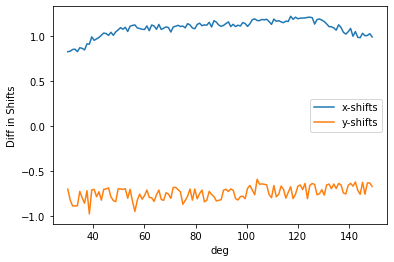

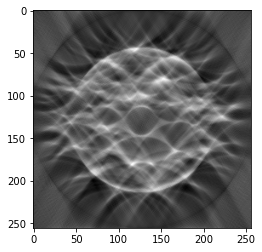

In [8]:
# standard shift correction
align_shifts = np.zeros_like(shifts)
aligned_projs, align_shifts[:,1], align_shifts[:,0], error = tomopy.align_seq(projs, thetas, iters=100, upsample_factor=100, blur=False, save=True)

# plot difference
diff_shifts = shifts + align_shifts
pl.plot(np.rad2deg(thetas), diff_shifts[:, 1], label="x-shifts")
pl.plot(np.rad2deg(thetas), diff_shifts[:, 0], label="y-shifts")
pl.xlabel("deg")
pl.ylabel("Diff in Shifts")
pl.legend()
pl.show()

# recon after shifts corrected
rec = tomopy.recon(aligned_projs, thetas, algorithm="sirt", num_iter=30)

pl.imshow(rec[rec.shape[0]//2])
pl.show()

min err: 0.9249660557288071, orig err: 224.06989931419255, x_shift: -0.07887996927216814, y_shift: -0.7442810558134535, z_shift: 0.37818448362367024, center_shift: 0.7754749559438666


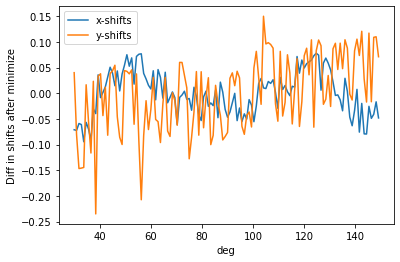

In [9]:
# calculate shift error with x,y,z motion applied
# TODO: should we include center shift?
def calc_shift_error(thetas, shifts, true_shifts):
    # calculate Y-shift that reduces error
    options = {'ftol':0.000001}

    def _y_cost(args):
        y_shift = args
        return np.sum(np.square(true_shifts[:,0] - (shifts[:,0] - y_shift)))

    res = minimize(_y_cost, (0.0,), method='Powell', options=options)
    y_shift = float(res.x)

    # now calculate x_shift and z_shift that reduces error in shifts
    # z_shift is the sin(theta) and x_shift is the cos(theta)
    def _xz_cost(args):
        x_shift, z_shift, center_shift = args
        new_shifts = shifts[:,1] - (z_shift * np.sin(thetas) + x_shift * np.cos(thetas) + center_shift)
        #x_shift, z_shift = args
        #new_shifts = shifts[:,1] - (z_shift * np.sin(thetas) + x_shift * np.cos(thetas))
        return np.sum(np.square(true_shifts[:,1] - new_shifts))

    res = minimize(_xz_cost, (0.0, 0.0, 0.0), method='Powell', options=options)
    x_shift, z_shift, center_shift = res.x
    #res = minimize(_xz_cost, (0.0, 0.0), method='Powell', options=options)
    #center_shift = 0
    #x_shift, z_shift, = res.x
    new_shifts = shifts.copy()
    new_shifts[:,0] -= y_shift
    new_shifts[:,1] -= z_shift * np.sin(thetas) + x_shift * np.cos(thetas) + center_shift
    error = np.sum(np.square(true_shifts - new_shifts))
    return x_shift, y_shift, z_shift, center_shift, error

# minimize error in shift output
x_shift, y_shift, z_shift, center_shift, error = calc_shift_error(thetas, align_shifts, -shifts)
# calc shift error before minimization
orig_error = np.sum(np.square(shifts + align_shifts))
print(f"min err: {error}, orig err: {orig_error}, x_shift: {x_shift}, y_shift: {y_shift}, z_shift: {z_shift}, center_shift: {center_shift}")

# calculate aligned shifts with minimized error for display
align_shifts_min_err = np.copy(align_shifts)
align_shifts_min_err[:, 0] -= y_shift
align_shifts_min_err[:, 1] -= z_shift * np.sin(thetas) + x_shift * np.cos(thetas) + center_shift

diff_shifts = shifts + align_shifts_min_err
pl.plot(np.rad2deg(thetas), diff_shifts[:, 1], label="x-shifts")
pl.plot(np.rad2deg(thetas), diff_shifts[:, 0], label="y-shifts")
pl.xlabel("deg")
pl.ylabel("Diff in shifts after minimize")
pl.legend()
pl.show()
